Notebook setup — imports and configuration


In [10]:
# Cell 1 — Setup
# Imports and basic configuration
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')


DATA_PATH = Path('/content/drive/MyDrive/Soft Computing Compititon/intelligent_streetlight_dataset.csv')
OUTPUT_TIMINGS = Path('/content/drive/MyDrive/Soft Computing Compititon/optimized_signal_timings.csv')
OUTPUT_METRICS = Path('/content/drive/MyDrive/Soft Computing Compititon/optimization_metrics.csv')
OUTPUT_PLOT = Path('/content/drive/MyDrive/Soft Computing Compititon/ga_convergence.png')


# GA hyperparameters (you can tune these)
POP_SIZE = 80
GENERATIONS = 200
MUTATION_RATE = 0.12
CROSSOVER_RATE = 0.9
SEED = 42


random.seed(SEED)
np.random.seed(SEED)


print('Setup complete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete


Load dataset and preview

In [11]:
if not DATA_PATH.exists():
  raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")


df = pd.read_csv(DATA_PATH, parse_dates=['Timestamp'] if 'Timestamp' in pd.read_csv(DATA_PATH, nrows=0).columns else None)


print('Rows:', len(df))
print('\nColumns:', df.columns.tolist())


df.head()

Rows: 1000

Columns: ['Timestamp', 'Street ID', 'Day/Night', 'Traffic Count', 'Traffic Density', 'Traffic Speed', 'Ambient Light (lux)', 'Weather', 'Energy Consumption (kWh)', 'Power State', 'Dim Level', 'Latitude', 'Longitude', 'Special Event', 'Holiday/Weekend']


,Timestamp,Street ID,Day/Night,Traffic Count,Traffic Density,Traffic Speed,Ambient Light (lux),Weather,Energy Consumption (kWh),Power State,Dim Level,Latitude,Longitude,Special Event,Holiday/Weekend
0,2024-01-21 05:27:00,8,Day,154,41.750173,59.383884,172.439065,Clear,0.37,1,50,40.877092,-73.813538,1,0
1,2024-01-11 12:15:00,3,Night,103,30.949961,24.208586,189.339042,Rainy,0.00,0,100,40.862553,-74.125943,0,0
2,2024-01-29 20:18:00,9,Night,203,32.089607,29.733312,200.236036,Cloudy,0.00,0,75,40.809826,-73.853724,1,0
3,2024-01-05 13:42:00,5,Day,161,27.758249,27.850047,197.078404,Cloudy,0.78,1,100,40.529601,-74.073302,0,0
4,2024-01-08 07:45:00,1,Night,55,41.492456,59.282133,279.109775,Clear,0.46,1,50,40.565817,-74.116742,1,1


Aggregate traffic by junction (Street ID)

In [12]:
# Cell 3 — Aggregate by junction
# We compute average traffic per Street ID and a flag if any row had a special event
if 'Street ID' not in df.columns or 'Traffic Count' not in df.columns:
  raise ValueError("CSV must contain 'Street ID' and 'Traffic Count' columns")


agg = df.groupby('Street ID').agg({'Traffic Count': 'mean', 'Special Event': 'max'}).reset_index().sort_values('Street ID')
agg.rename(columns={'Traffic Count': 'avg_traffic', 'Special Event': 'has_special'}, inplace=True)


agg

,Street ID,avg_traffic,has_special
0,1,166.456311,1
1,2,173.340000,1
2,3,180.056604,1
3,4,178.927835,1
4,5,181.526316,1
5,6,175.577778,1
6,7,182.422680,1
7,8,170.267327,1
8,9,181.964602,1
9,10,183.744898,1


Modeling assumptions and objective

In [13]:
def decode(individual, junction_ids):
  # individual is list [cycle_j1, green_j1, cycle_j2, green_j2, ...]
  res = {}
  for i, j in enumerate(junction_ids):
    cycle = individual[2*i]
    g = individual[2*i + 1]
    cycle = max(60.0, min(120.0, cycle))
    g = max(10.0, min(cycle - 10.0, g))
    res[j] = (cycle, g)
  return res

def evaluate(individual, agg, junction_ids, weights=(1.0, 30.0, 0.5)):
  decoded = decode(individual, junction_ids)
  total_veh = float(agg['avg_traffic'].sum())
  delay_weighted = 0.0
  stops_weighted = 0.0
  emergency_penalty = 0.0

  for _, row in agg.iterrows():
    j = row['Street ID']
    traffic = row['avg_traffic']
    cycle, g = decoded[j]
    red = cycle - g
    avg_delay = red / 2.0
    stops = red / cycle
    delay_weighted += avg_delay * traffic
    stops_weighted += stops * traffic
    if row['has_special'] == 1:
      target = 0.6 * cycle
      if g < target:
        emergency_penalty += (target - g) * traffic * 2.0

  delay_score = delay_weighted / total_veh
  stops_score = stops_weighted / total_veh
  alpha, beta, gamma = weights
  score = alpha * delay_score + beta * stops_score + gamma * (emergency_penalty / total_veh)
  return score

print('Model functions defined')

Model functions defined


Baseline for comparison

In [14]:
junction_ids = agg['Street ID'].tolist()


def build_baseline(junction_ids, cycle=90.0, green=45.0):
  ind = []
  for _ in junction_ids:
    ind += [cycle, green]
  return ind

baseline_ind = build_baseline(junction_ids)
baseline_score = evaluate(baseline_ind, agg, junction_ids)

# Simple metrics for baseline
def compute_metrics(individual, agg, junction_ids):
  decoded = decode(individual, junction_ids)
  total_veh = float(agg['avg_traffic'].sum())
  delays = []
  stops = []
  for _, row in agg.iterrows():
    j = row['Street ID']
    traffic = row['avg_traffic']
    cycle, g = decoded[j]
    red = cycle - g
    avg_delay = red / 2.0
    stops_prob = red / cycle
    delays.append((avg_delay, traffic))
    stops.append((stops_prob, traffic))
  avg_delay = sum(d * t for d, t in delays) / total_veh
  avg_stops = sum(s * t for s, t in stops) / total_veh
  return avg_delay, avg_stops

baseline_delay, baseline_stops = compute_metrics(baseline_ind, agg, junction_ids)
print('Baseline score:', baseline_score)
print('Baseline delay (s/veh):', baseline_delay)
print('Baseline stops per vehicle:', baseline_stops)

Baseline score: 46.50000000000001
Baseline delay (s/veh): 22.500000000000004
Baseline stops per vehicle: 0.5000000000000001


Genetic Algorithm implementation

In [15]:
def run_ga(agg, pop_size=POP_SIZE, gens=GENERATIONS, mut_rate=MUTATION_RATE, cross_rate=CROSSOVER_RATE):
  junction_ids = agg['Street ID'].tolist()
  n = len(junction_ids)
  def init_individual():
    ind = []
    for _ in junction_ids:
      cycle = random.uniform(60.0, 120.0)
      g = random.uniform(10.0, cycle - 10.0)
      ind += [cycle, g]
    return ind

  pop = [init_individual() for _ in range(pop_size)]
  scores = [evaluate(ind, agg, junction_ids) for ind in pop]
  best_history = []

  for gen in range(gens):
    new_pop = []
    while len(new_pop) < pop_size:
      # tournament selection
      def tournament():
        a, b = random.sample(range(pop_size), 2)
        return pop[a] if scores[a] < scores[b] else pop[b]
      p1 = tournament()
      p2 = tournament()
      # crossover
      if random.random() < cross_rate:
        cut = random.randint(1, len(p1) - 2)
        c1 = p1[:cut] + p2[cut:]
        c2 = p2[:cut] + p1[cut:]
      else:
        c1 = p1.copy(); c2 = p2.copy()
      # mutation
      def mutate(child):
        for i in range(len(child)):
          if random.random() < mut_rate:
            if i % 2 == 0:
              child[i] += random.gauss(0, 6.0)
            else:
              child[i] += random.gauss(0, 4.0)
        return child
      c1 = mutate(c1); c2 = mutate(c2)
      new_pop.extend([c1, c2])

    pop = new_pop[:pop_size]
    scores = [evaluate(ind, agg, junction_ids) for ind in pop]
    best_idx = int(np.argmin(scores))
    best_history.append(scores[best_idx])
    if gen % 20 == 0 or gen == gens - 1:
      print(f"Gen {gen}: best score = {scores[best_idx]:.6f}")

  best_idx = int(np.argmin(scores))
  best_ind = pop[best_idx]
  best_score = scores[best_idx]
  decoded_best = decode(best_ind, junction_ids)
  return best_ind, decoded_best, best_score, best_history

print('GA functions ready')

GA functions ready


Run the GA and inspect results

In [16]:
best_ind, decoded_best, best_score, history = run_ga(agg)

# Build timings DataFrame
rows = []
for j in agg['Street ID'].tolist():
  cycle, g = decoded_best[j]
  rows.append({'Street ID': int(j), 'Cycle Time (s)': round(cycle,2), 'Green Main (s)': round(g,2), 'Red (s)': round(cycle - g,2)})

timings_df = pd.DataFrame(rows).sort_values('Street ID')

timings_df

Gen 0: best score = 29.732412
Gen 20: best score = 8.797369
Gen 40: best score = 8.534212
Gen 60: best score = 8.378508
Gen 80: best score = 8.143929
Gen 100: best score = 7.889271
Gen 120: best score = 7.774234
Gen 140: best score = 7.612867
Gen 160: best score = 7.511985
Gen 180: best score = 7.500000
Gen 199: best score = 7.500000


,Street ID,Cycle Time (s),Green Main (s),Red (s)
0,1,120.0,110.0,10.0
1,2,120.0,110.0,10.0
2,3,120.0,110.0,10.0
3,4,120.0,110.0,10.0
4,5,120.0,110.0,10.0
5,6,120.0,110.0,10.0
6,7,120.0,110.0,10.0
7,8,120.0,110.0,10.0
8,9,120.0,110.0,10.0
9,10,120.0,110.0,10.0


Before vs After metrics and save outputs

               Metric  Before    After
Average Delay (s/veh)    22.5 5.000000
    Stops per vehicle     0.5 0.083333
      Objective score    46.5 7.500000


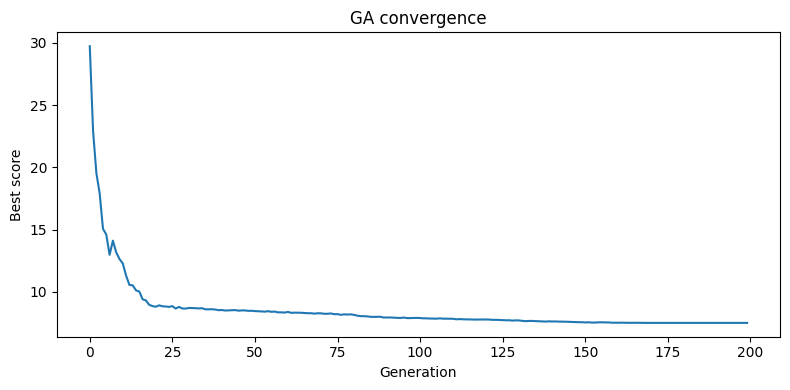

Saved: /content/drive/MyDrive/Soft Computing Compititon/optimized_signal_timings.csv /content/drive/MyDrive/Soft Computing Compititon/optimization_metrics.csv /content/drive/MyDrive/Soft Computing Compititon/ga_convergence.png


In [17]:
opt_delay, opt_stops = compute_metrics(best_ind, agg, agg['Street ID'].tolist())

metrics_df = pd.DataFrame([
  {'Metric':'Average Delay (s/veh)', 'Before': baseline_delay, 'After': opt_delay},
  {'Metric':'Stops per vehicle', 'Before': baseline_stops, 'After': opt_stops},
  {'Metric':'Objective score', 'Before': baseline_score, 'After': best_score}
])

print(metrics_df.to_string(index=False))

# Save results
OUTPUT_TIMINGS.parent.mkdir(parents=True, exist_ok=True)
timings_df.to_csv(OUTPUT_TIMINGS, index=False)
metrics_df.to_csv(OUTPUT_METRICS, index=False)

# Plot GA convergence
plt.figure(figsize=(8,4))
plt.plot(history)
plt.xlabel('Generation')
plt.ylabel('Best score')
plt.title('GA convergence')
plt.tight_layout()
plt.savefig(OUTPUT_PLOT)
plt.show()

print('Saved:', OUTPUT_TIMINGS, OUTPUT_METRICS, OUTPUT_PLOT)